# Práctica 2: Propiedades estadísticas de la lengua

## Fecha de entrega: 2 de Marzo de 2025 11:59pm



In [ ]:
#!jupytext --set-formats ipynb,py 02_stats_properties.ipynb

In [ ]:
# Bibliotecas
import random 
import string
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Descargadas
import spacy
from spacy import displacy
!python -m spacy download es_core_news_md

## 1. 
Verificar si la ley de Zipf se cumple en un lenguaje artificial creado por ustedes.

- *Ejemplo:* Un "lenguaje artificial" podría ser simplemente un texto donde las secuencias de caracteres fueron generadas aleatoriamente.

In [3]:
def generar_palabra_aleatoria(min_len=4, max_len=10):
    """
    Genera una palabra aleatoria compuesta por caracteres en minúscula del alfabeto inglés.

    Parameters
    ----------
    min_len : int, optional
        Longitud mínima de la palabra generada (por defecto 4).
    max_len : int, optional
        Longitud máxima de la palabra generada (por defecto 10).

    Returns
    -------
    str
        Palabra aleatoria con una longitud entre min_len y max_len.
    """
    # Generar una longitud n random
    longitud = random.randint(min_len, max_len)
    # Generar n caracteres random y unirlos para formar la palabra
    return ''.join(random.choices(string.ascii_lowercase, k=longitud))


In [4]:
# Generamos un vocabulario de 5,000 palabras aleatorias
vocabulario = [generar_palabra_aleatoria() for _ in range(5000)]

# Generamos un corpus de 100,000 palabras, escogidas aleatoriamente (uniforme) del vocabulario
corpus = ' '.join(random.choices(vocabulario, k=100000))

# Contar la frecuencia de cada palabra 
frecuencias = Counter(corpus.split())

# Crear un DataFrame con columnas 'word' y 'freq', ordenado de mayor a menor frecuencia
corpus_freqs = pd.DataFrame(list(frecuencias.items()), columns=['word', 'freq'])
corpus_freqs = corpus_freqs.sort_values(by='freq', ascending=False).reset_index(drop=True)

corpus_freqs.head(5)

,word,freq
0,cmdbz,39
1,eeqoy,37
2,trucq,36
3,lhhgozxuii,36
4,vxwbgw,35


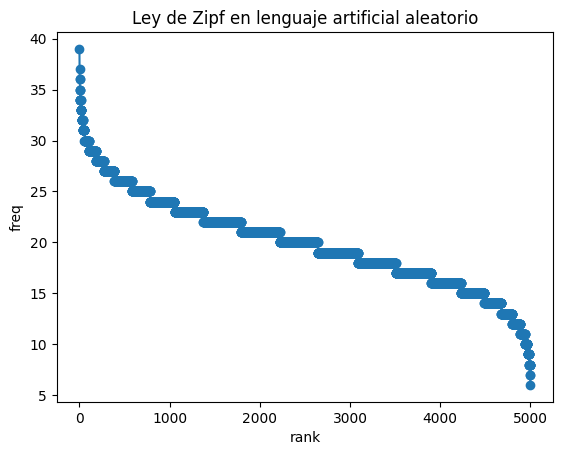

In [5]:
# Graficar ley de zipf
corpus_freqs["freq"].plot(marker="o")
plt.title('Ley de Zipf en lenguaje artificial aleatorio')
plt.xlabel('rank')
plt.ylabel('freq')
plt.show()

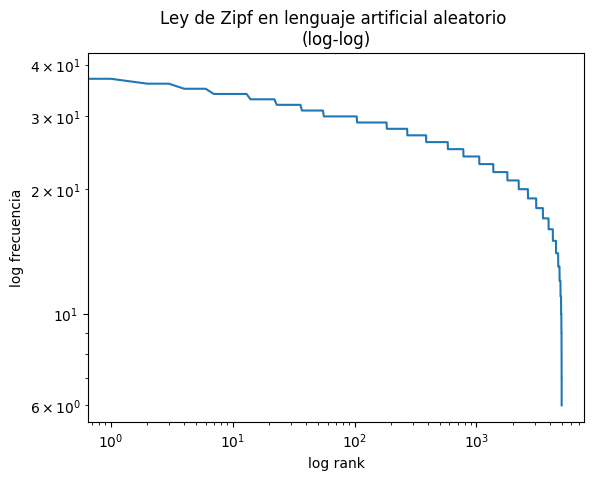

In [6]:
# Aplicando logaritmo para la visualizacion
corpus_freqs['freq'].plot(loglog=True, legend=False)
plt.title('Ley de Zipf en lenguaje artificial aleatorio \n(log-log)')
plt.xlabel('log rank')
plt.ylabel('log frecuencia')
plt.show()

Podemos observar que la gráfica difiere notablemente de la distribución típica de la ley de Zipf en lenguajes naturales. Aunque la forma general mantiene una tendencia decreciente, la curva es más plana en comparación con la ley de Zipf esperada. Es decir, la diferencia entre las palabras más comunes y las menos comunes no es tan pronunciada. Esto sugiere que, en un lenguaje artificial generado aleatoriamente, no emergen las mismas estructuras jerárquicas de frecuencia que en los lenguajes naturales, donde ciertas palabras predominan debido a patrones semánticos y sintácticos propios del uso del idioma.

## 2.
Explorar `datasets` del sitio [Hugging Face](https://huggingface.co/datasets) y elegir documentos de diferentes dominios en Español (al menos 3). Realizar reconocimiento de entidades nombradas (NER).

- Pueden utilizar subconjuntos de los datasets encontrados
- Mostrar resultados del reconocimiento
- Una distribución de frecuencias de las etiquetas más comunes en cada dominio
- Comentarios generales del desempeño observado.

*Sugerencias: Spacy, CoreNLP (puede ser cualquier otra herramienta)*

**Dataset elegidos:** 

Dataset de Noticias: Nicky0007/cointelegraph_noticias_Es

Dataset de Recetas: somosnlp/recetas-cocina

Dataset de Comentarios Suicidas: somosnlp-hackathon-2023/suicide-comments-es 

### Cargar los datos y preprocesarlos

In [7]:
df_recetas = pd.read_csv("./data/dataset_recetas.csv")
df_noticias = pd.read_csv("./data/dataset_noticias.csv")
df_suicidio = pd.read_csv("./data/suicide_comments_es.csv")

In [8]:
df_suicidio.head(2)

,Text,Label
0,Pablo Picasso es un artista famoso de principi...,0
1,"Las mujeres son extrañas, sé lo que quieres de...",0


In [9]:
# Selecccionamos las columnas con el texto que analizaremos
df_recetas = df_recetas.dropna(subset=['steps'])
df_noticias = df_noticias.dropna(subset=['description'])
df_suicidio = df_suicidio.dropna(subset=['Text'])

# Renombrar columnas a "texto" en cada DataFrame
df_recetas = df_recetas.rename(columns={'steps': 'texto'})
df_noticias = df_noticias.rename(columns={'description': 'texto'})
df_suicidio = df_suicidio.rename(columns={'Text': 'texto'})

### NER

In [10]:
nlp = spacy.load("es_core_news_md")

In [11]:
def extract_entities(df, text_column="texto", n=100):
    """
    Extrae entidades nombradas de un subconjunto aleatorio del dataset.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame que contiene los textos a procesar.
    text_column : str
        Nombre de la columna que contiene los textos.
    n : int, optional
        Número de ejemplos aleatorios a procesar (default es 100).

    Returns
    -------
    pandas.DataFrame
        DataFrame con una nueva columna 'entities' donde cada fila contiene 
        las entidades reconocidas en el texto correspondiente.
    """
    # Seleccionar aleatoriamente `n` ejemplos del dataset
    subset_df = df.sample(n=min(n, len(df)), random_state=42)

    # Aplicar NER a los textos seleccionados
    subset_df['entities'] = subset_df[text_column].apply(lambda text: [(ent.text, ent.label_) for ent in nlp(text).ents])

    return subset_df

In [12]:
# Aplicar la función a los datasets
df_noticias_sampled = extract_entities(df_noticias, n=100)
df_recetas_sampled = extract_entities(df_recetas, n=100)
df_suicidio_sampled = extract_entities(df_suicidio, n=100)

#### Visualizar algunos ejemplos

In [28]:
def visualize_ner(df, text_column="texto", num_examples=5):
    """
    Visualiza el reconocimiento de entidades nombradas en textos usando displacy.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame que contiene los textos procesados y las entidades extraídas.
    text_column : str
        Nombre de la columna que contiene los textos.
    num_examples : int, optional
        Número de ejemplos a visualizar (default es 5).

    Returns
    -------
    None
        Muestra la visualización de `displacy` con las entidades destacadas.
    """
    # Seleccionar `num_examples` aleatorios
    sample_texts = df.sample(n=min(num_examples, len(df)), random_state=121)[text_column].tolist()

    for text in sample_texts:
        doc = nlp(text)
        displacy.render(doc, style="ent", jupyter=True)


In [31]:
# Visualizar entidades nombradas en cada dataset
print("Dataset de Noticias: ")
visualize_ner(df_noticias_sampled, num_examples=3)
print("Dataset de Recetas: ")
visualize_ner(df_recetas_sampled, num_examples=2)
print("Dataset de Comentarios Sucidas: ")
visualize_ner(df_suicidio_sampled, num_examples=20)


Dataset de Noticias: 


Dataset de Recetas: 


Dataset de Comentarios Sucidas: 


#### Contar la frecuencia de las etiquetas y graficar distribución  

In [15]:
def count_entity_labels(df):
    """
    Cuenta la frecuencia de cada tipo de entidad nombrada en un DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame que contiene una columna 'entities', donde cada fila 
        tiene una lista de tuplas (texto de la entidad, etiqueta de entidad).

    Returns
    -------
    collections.Counter
        Un diccionario con la frecuencia de cada tipo de entidad.
    """
    all_labels = [ent[1] for entities in df['entities'] for ent in entities]
    return Counter(all_labels)

In [16]:
# Contar etiquetas por dataset
freq_noticias = count_entity_labels(df_noticias_sampled)
freq_recetas = count_entity_labels(df_recetas_sampled)
freq_suicidio = count_entity_labels(df_suicidio_sampled)

print(freq_noticias)  
print(freq_recetas)
print(freq_suicidio)


Counter({'MISC': 56, 'PER': 44, 'LOC': 37, 'ORG': 36})
Counter({'MISC': 419, 'LOC': 134, 'PER': 67, 'ORG': 25})
Counter({'MISC': 21, 'LOC': 11, 'PER': 8, 'ORG': 2})


In [17]:
def explain_entity_labels(freq):
    """
    Imprime el significado de cada etiqueta de entidad encontrada en un dataset.

    Parameters
    ----------
    freq : collections.Counter
        Diccionario con la frecuencia de cada tipo de entidad.

    Returns
    -------
    None
        Muestra en pantalla cada etiqueta junto con su descripción.
    """
    print("\nSignificado de las etiquetas NER detectadas:\n")
    for label in freq.keys():
        description = spacy.explain(label)
        if description:
            print(f"{label} --> {description}")
        else:
            print(f"{label} --> Descripción no encontrada en spaCy.")

In [18]:
# Aplicar la función a cada dataset
print("Dataset Noticias:")
explain_entity_labels(freq_noticias)

print("\nDataset Recetas:")
explain_entity_labels(freq_recetas)

print("\nDataset Comentarios Suicidas:")
explain_entity_labels(freq_suicidio)

Dataset Noticias:

Significado de las etiquetas NER detectadas:

PER --> Named person or family.
MISC --> Miscellaneous entities, e.g. events, nationalities, products or works of art
LOC --> Non-GPE locations, mountain ranges, bodies of water
ORG --> Companies, agencies, institutions, etc.

Dataset Recetas:

Significado de las etiquetas NER detectadas:

PER --> Named person or family.
MISC --> Miscellaneous entities, e.g. events, nationalities, products or works of art
LOC --> Non-GPE locations, mountain ranges, bodies of water
ORG --> Companies, agencies, institutions, etc.

Dataset Comentarios Suicidas:

Significado de las etiquetas NER detectadas:

MISC --> Miscellaneous entities, e.g. events, nationalities, products or works of art
PER --> Named person or family.
ORG --> Companies, agencies, institutions, etc.
LOC --> Non-GPE locations, mountain ranges, bodies of water


In [22]:
def plot_entity_distribution(freq, dataset_name):
    """
    Genera un gráfico de barras con la distribución de entidades nombradas.

    Parameters
    ----------
    freq : collections.Counter
        Diccionario con la frecuencia de cada entidad extraída.
    dataset_name : str
        Nombre del dataset analizado (para etiquetar la gráfica).

    Returns
    -------
    None
        Muestra un gráfico de barras con la distribución de entidades.
    """
    if not freq:
        print(f"No se encontraron entidades en {dataset_name}.")
        return

    labels, values = zip(*freq.items())  # Extraer etiquetas y sus frecuencias
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values)
    plt.title(f"Distribución de entidades en {dataset_name}")
    plt.xticks(rotation=45)
    plt.xlabel("Tipo de entidad")
    plt.ylabel("Frecuencia")
    plt.show()


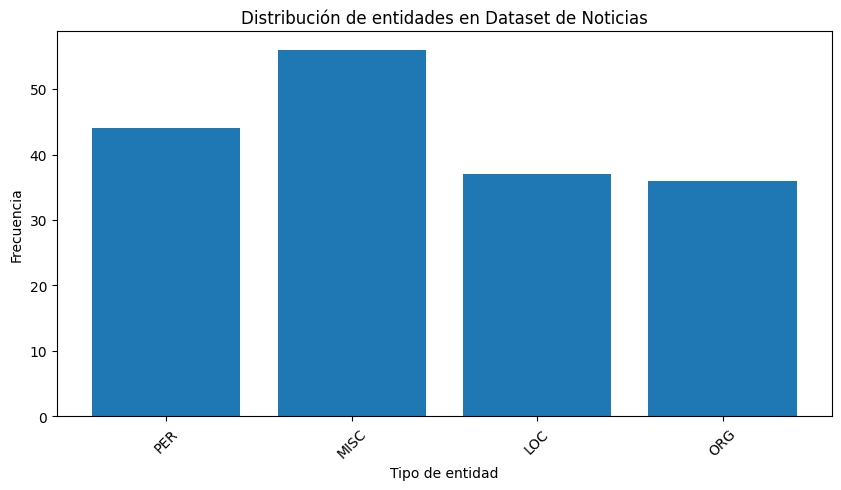

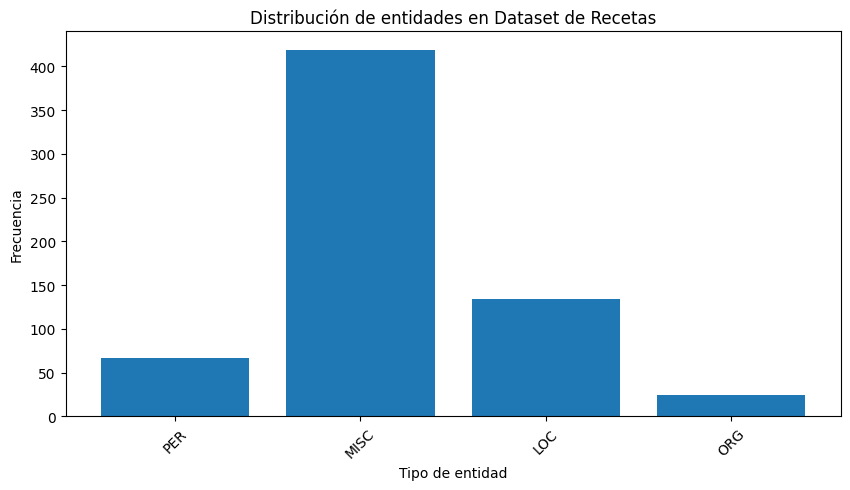

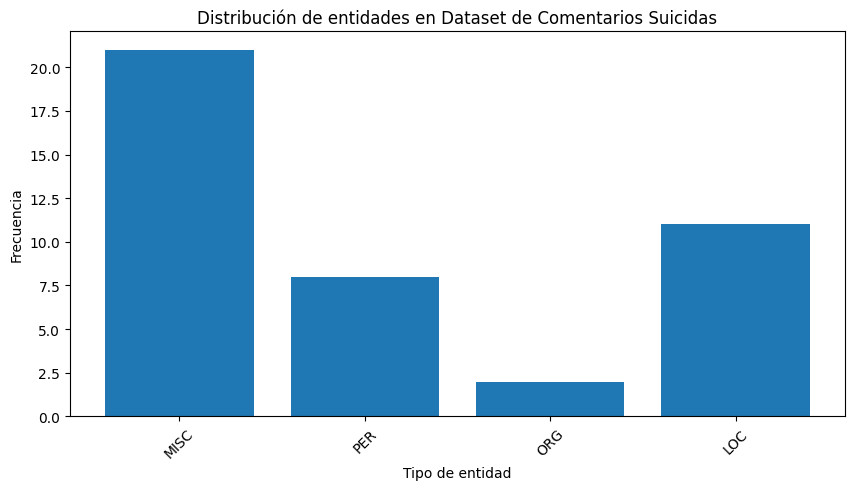

In [21]:
# Graficar distribución de entidades en cada dataset
plot_entity_distribution(freq_noticias, "Dataset de Noticias")
plot_entity_distribution(freq_recetas, "Dataset de Recetas")
plot_entity_distribution(freq_suicidio, "Dataset de Comentarios Suicidas")

#### Conclusiones

1. **Dataset de Noticias**

    El modelo de spaCy presentó un desempeño sólido en este dataset, logrando identificar correctamente organizaciones (ORG), ubicaciones (LOC) y otras entidades relevantes dentro del contexto informativo. Esto era de esperarse, ya que el modelo ha sido entrenado con datos similares a los textos periodísticos, lo que le permite reconocer con precisión nombres de países, instituciones y términos económicos. Si bien se encontraron algunos errores menores, en general, la clasificación fue confiable y sin un uso excesivo de etiquetas erróneas. En este contexto, el modelo puede considerarse una herramienta útil para la extracción de entidades en noticias.

2. **Dataset de Recetas**

    El reconocimiento de entidades en este dataset fue considerablemente menos preciso. El modelo identificó incorrectamente varios verbos y términos culinarios como nombres de lugares o categorías misceláneas, lo que sugiere una falta de adaptación a este dominio. Palabras como "Batimos" y "Calentar" fueron etiquetadas como ubicaciones (LOC), lo que indica que el modelo no pudo diferenciar entre acciones y nombres propios dentro del contexto gastronómico. Además, la etiqueta MISC fue asignada con demasiada frecuencia, lo que sugiere que el modelo estaba "adivinando" categorías en lugar de hacer una identificación clara. Para mejorar la precisión en este tipo de textos, sería recomendable entrenar un modelo especializado en terminología de cocina o utilizar enfoques más adaptados al contexto.

3. **Dataset de Comentarios Suicidas**

    El desempeño del modelo en este dataset fue adecuado, ya que no identificó entidades de manera excesiva ni forzó etiquetas en textos donde no había nombres propios relevantes. Dado que estos comentarios no suelen contener nombres de lugares, organizaciones o personas, el hecho de que el modelo haya realizado pocas detecciones sugiere que está operando con un criterio razonable. Si bien hubo algunas etiquetas que podrían considerarse innecesarias, en términos generales, el modelo no cometió errores graves. Esto indica que, en textos conversacionales o de carácter subjetivo, spaCy tiende a ser más conservador en la identificación de entidades, lo cual puede ser ventajoso en ciertos escenarios.